# Anlaysing Ticket inspection logs

How many people get caught per bus?

Is there any obvious patterning? 

How sparse / dense is the data 
- even though there are 60,000 entries. Given that there are ~400 bus stops and the bus network operates ~18 hours a day. The data is likely rather sparse

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [191]:
Inspections = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe2/Inspections.csv", parse_dates = ["Start_Dtime"])
Inspections.head(5)

,Date,Start_Dtime,End_Dtime,Stop_code,Line,Repeat_bus,Visit_number,Unvalidated,Pre_2019
0,2016-02-12,2016-02-12 13:16:51,2016-02-12 13:17:17,7820064-1,1,0.0,1,0,True
1,2016-02-12,2016-02-12 13:33:31,2016-02-12 13:34:12,7820064-1,1,1.0,1,1,True
2,2016-02-12,2016-02-12 13:50:55,2016-02-12 13:51:11,7820064-1,15,0.0,1,1,True
3,2016-02-12,2016-02-12 13:12:26,2016-02-12 13:14:13,7820064-1,20,0.0,1,14,True
4,2016-02-12,2016-02-12 13:19:15,2016-02-12 13:20:15,7820064-1,26,0.0,1,9,True


### Frequency of Unvalidated Individuals per Bus

In [192]:
Temp = Inspections.copy()
Temp["Unvalidated"] = Inspections["Unvalidated"].map(lambda x : "15+" if x > 15 else x)
Temp.head()

,Date,Start_Dtime,End_Dtime,Stop_code,Line,Repeat_bus,Visit_number,Unvalidated,Pre_2019
0,2016-02-12,2016-02-12 13:16:51,2016-02-12 13:17:17,7820064-1,1,0.0,1,0,True
1,2016-02-12,2016-02-12 13:33:31,2016-02-12 13:34:12,7820064-1,1,1.0,1,1,True
2,2016-02-12,2016-02-12 13:50:55,2016-02-12 13:51:11,7820064-1,15,0.0,1,1,True
3,2016-02-12,2016-02-12 13:12:26,2016-02-12 13:14:13,7820064-1,20,0.0,1,14,True
4,2016-02-12,2016-02-12 13:19:15,2016-02-12 13:20:15,7820064-1,26,0.0,1,9,True


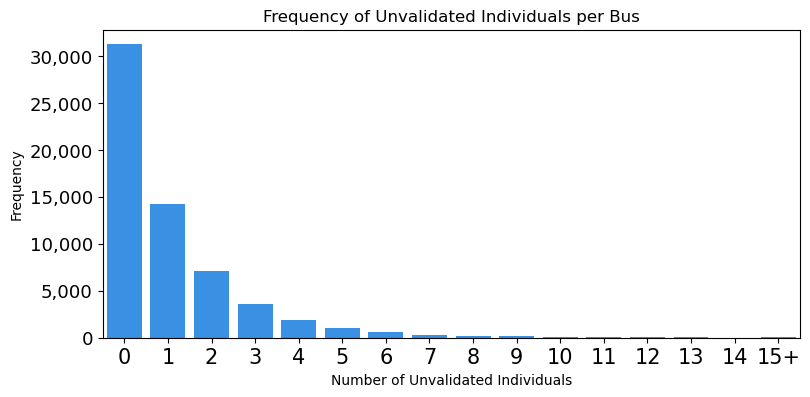

In [193]:
order  = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,"15+"]

plt.figure(figsize = (9,4))

sns.countplot(data = Temp, x = "Unvalidated", order = order, color = "dodgerblue")
plt.xlabel("Number of Unvalidated Individuals")
plt.ylabel("Frequency")
plt.title("Frequency of Unvalidated Individuals per Bus")

plt.xticks(size = "15")
plt.yticks(size = "13")

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig(
    "c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe3/unvalidated_countplot.svg",  
    format='svg',                 # explicitly specify format
    bbox_inches='tight'           # ensures labels/titles are not cut off
)

plt.show()

### Frequency of caught evadees over time 

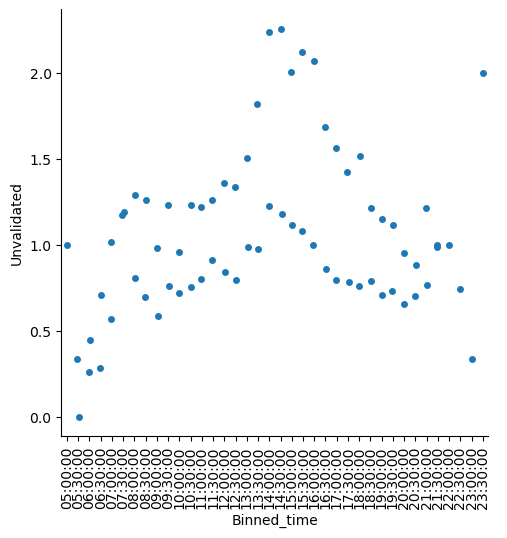

In [194]:
#Round Start_Dtime to 30-minute bins
Inspections["Binned_time"] = Inspections["Start_Dtime"].dt.floor("30min")  # '30T' = 30 minutes
Inspections["Binned_time"] = Inspections["Binned_time"].dt.time

Grouped = Inspections.groupby(["Binned_time", "Pre_2019"])["Unvalidated"].mean().reset_index()

sns.catplot(data = Grouped, x = "Binned_time", y = "Unvalidated")
plt.xticks(rotation = 90)
plt.show()

### Highlighting the low support for individual bus stops

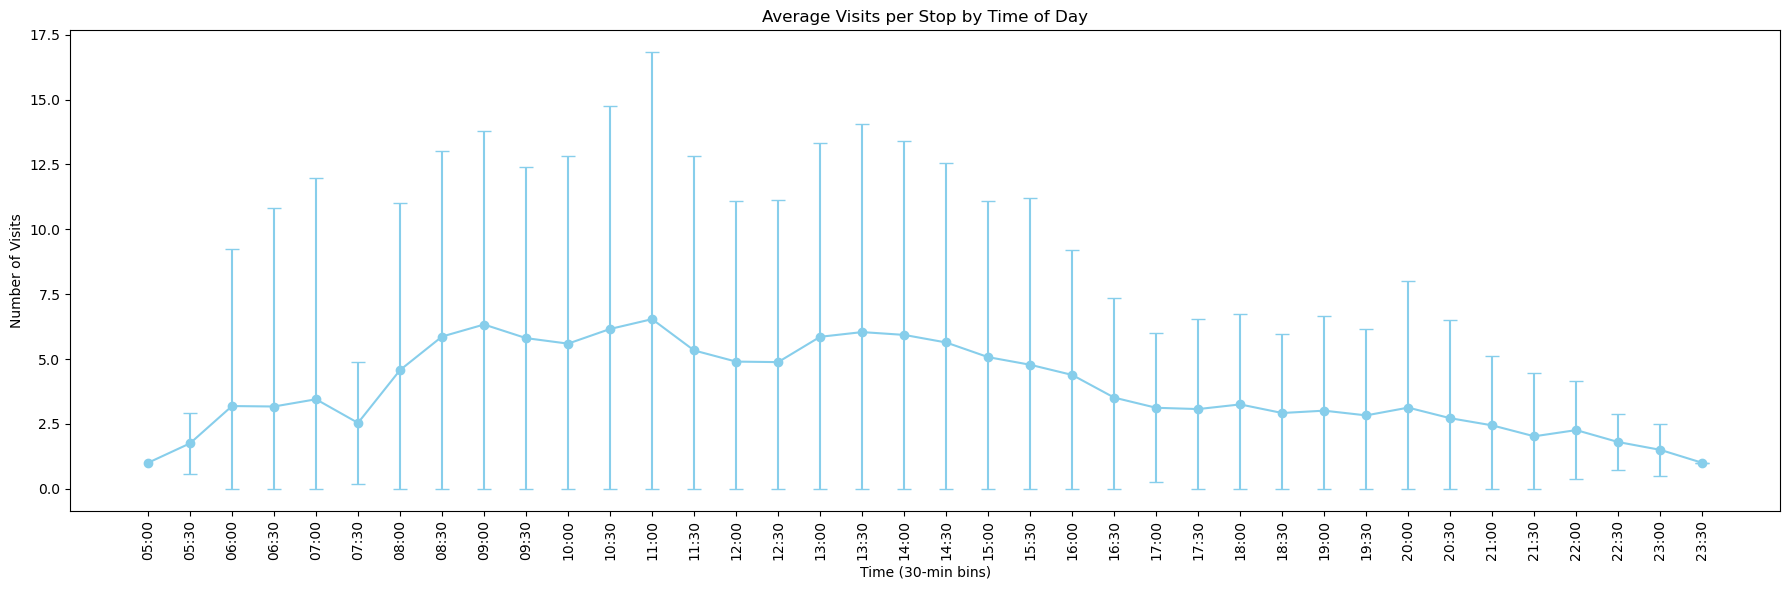

In [195]:
Inspections["Binned_day"] = Inspections["Start_Dtime"].dt.weekday

# number of times that a bus stop has been visited at that particualr time
Grouped = Inspections.groupby(["Stop_code", "Binned_time", "Binned_day"]).size().reset_index(name = "Support")

# Format Binned_time nicely
Grouped['Binned_time_str'] = Grouped['Binned_time'].apply(lambda t: t.strftime('%H:%M'))

# Sort Stop_code and Binned_time for consistent plotting
Grouped.sort_values(by='Binned_time', inplace=True)


# Calculate mean and SD
summary = Grouped.groupby('Binned_time_str')['Support'].agg(['mean','std']).reset_index()
summary['lower'] = np.maximum(summary['mean'] - summary['std'], 0)  # clip at 0
summary['upper'] = summary['mean'] + summary['std']

plt.figure(figsize=(18,6))
plt.errorbar(
    x=summary['Binned_time_str'],
    y=summary['mean'],
    yerr=[summary['mean'] - summary['lower'], summary['upper'] - summary['mean']],
    fmt='o-', color='skyblue', capsize=5
)

plt.xticks(rotation=90)
plt.xlabel("Time (30-min bins)")
plt.ylabel("Number of Visits")
plt.title("Average Visits per Stop by Time of Day")
plt.tight_layout()

plt.savefig(
    "c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe3/support_plot.svg",  
    format='svg',                 # explicitly specify format
    bbox_inches='tight'           # ensures labels/titles are not cut off
)

plt.show()


In [196]:
Inspections.head()

,Date,Start_Dtime,End_Dtime,Stop_code,Line,Repeat_bus,Visit_number,Unvalidated,Pre_2019,Binned_time,Binned_day
0,2016-02-12,2016-02-12 13:16:51,2016-02-12 13:17:17,7820064-1,1,0.0,1,0,True,13:00:00,4
1,2016-02-12,2016-02-12 13:33:31,2016-02-12 13:34:12,7820064-1,1,1.0,1,1,True,13:30:00,4
2,2016-02-12,2016-02-12 13:50:55,2016-02-12 13:51:11,7820064-1,15,0.0,1,1,True,13:30:00,4
3,2016-02-12,2016-02-12 13:12:26,2016-02-12 13:14:13,7820064-1,20,0.0,1,14,True,13:00:00,4
4,2016-02-12,2016-02-12 13:19:15,2016-02-12 13:20:15,7820064-1,26,0.0,1,9,True,13:00:00,4


### Showing data sparsity through a different angle

In [197]:
# All stops that have been visited 
print(Temp["Stop_code"].nunique())

# all stop codes within tartu
All_stops = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe4/Unique_stops.csv")
print(All_stops["Stop_ID"].nunique())

# Stops that have NEVER been visited before!!
Missing_stops =  set(All_stops["Stop_ID"].unique()) - set(Temp["Stop_code"].unique())
Temp = Inspections.groupby(["Stop_code"]).size().reset_index(name = "visit_number")


dic = {Missing_stop : 0 for Missing_stop in Missing_stops}
dic_df = pd.DataFrame(dic.items(), columns = ["Stop_code", "visit_number"])

Final_df = pd.concat([Temp, dic_df])

293
454


In [198]:
453 - 293

160

In [199]:
Final_df["visit_number"].value_counts()

visit_number
0      162
1       34
2       22
5       12
3       11
      ... 
801      1
381      1
272      1
37       1
194      1
Name: count, Length: 155, dtype: int64

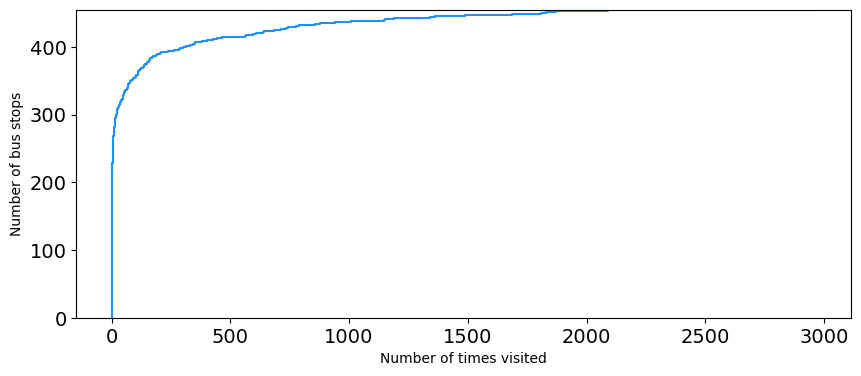

In [200]:
plt.figure(figsize = (10, 4))

sns.ecdfplot(data=Final_df, x="visit_number", color = "dodgerblue", stat = "count")
plt.xlabel("Number of times visited")
plt.ylabel("Number of bus stops")
plt.xticks(size = "14")
plt.yticks(size = "14")
plt.savefig(
    "c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe3/Stop_visit_ECDFplot.svg", 
    format='svg',              
    bbox_inches='tight'          
)
plt.show()
